In [1]:
import sys
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../gmm_modules/')
from metrics import metric_boxplot, plot_means, plot_means_with_percentile
from metrics import get_last_dir_n, load_metrics, init_metrics
from metrics import mean_metric, dublicate_metric, get_percentiles
from metrics import create_metrics_dict_by_clf, create_metrics_dict_by_clf_with_percentile

%matplotlib inline

** Этапы **

    1) Сохранение/загрузка метрик
        - сохранение чисто такое же как и в вычислении метрик
        - а вот загрузку надо перенести в metrics.py
        
    2) Построение графика
        - boxplot тот же
        
    3) Загрузка XGB
        - загрузку параметров не получается пока сделать единообразной(надо перепилить сохранение метрик)
        
    4) Загрузка IF и SVM
        - про загрузку та же фигня + надо добавить возможность из нескольких папок грузить
        
    5) Загрузка (1 + e)
        - прям очень надо из нескольких папок + отдельно массив с названиями алгоритмов
        
    6) Все алгоритмы на одном графике
        - подготовка данных
            - усреднение значений метрик
            - дублирование значений
            - загоняем метрики для всех алгоритмов в один словарь
            
        - графики средних значений
        
        - графики с погрешностями
            - вычисление перцентилей
            - загоняем метрики для всех алгоритмов в один словарь( + перцентили)
            - построение графиков с погрешностями

## Supervised(XGB с оптимальными параметрами)

Загрузка метрик для supervised алгоритмов

In [2]:
metrics_path = './metrics/xgb_opt'
supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_r = init_metrics(metrics_path)

PR AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

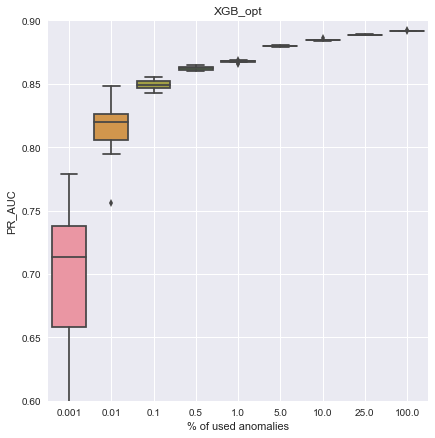

In [3]:
metric_boxplot(supervised_pr_aucs, ylabel='PR_AUC', ylim=(0.6, 0.9))

ROC AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

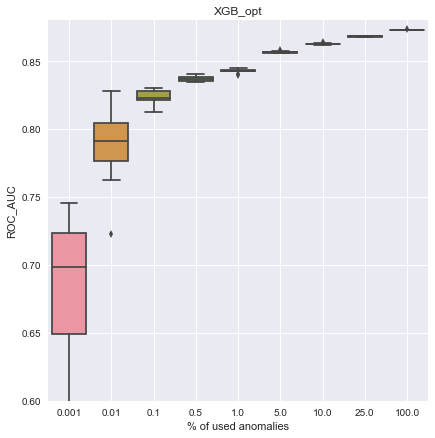

In [4]:
metric_boxplot(supervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.6, 0.88))

P@R:[0.8, 0.9, 0.95, 0.99] для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

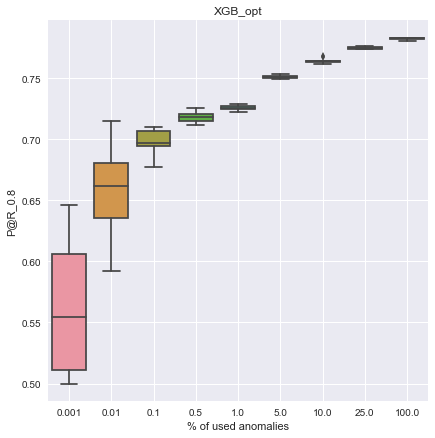

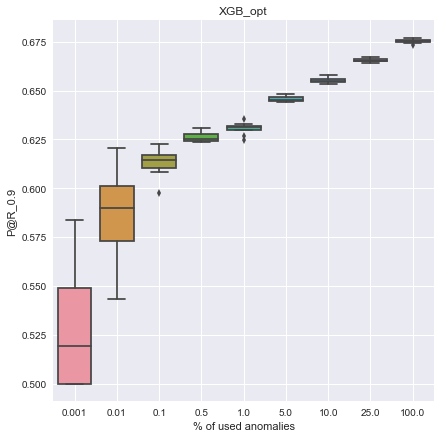

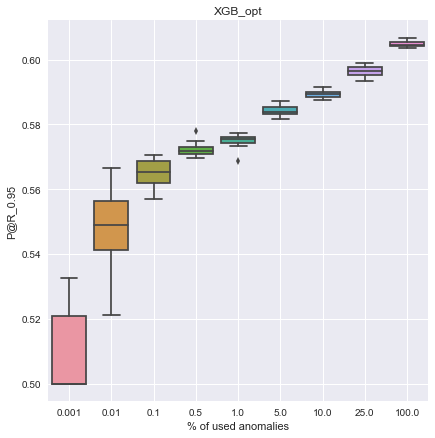

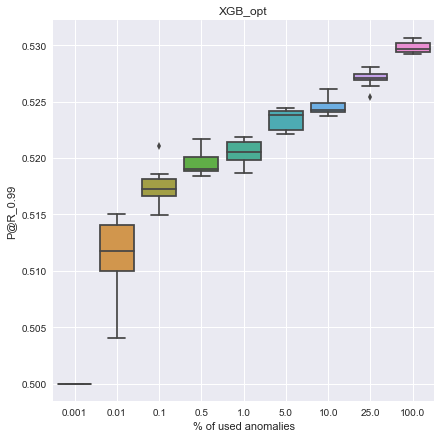

In [5]:
for k in supervised_p_at_r.keys():
    metric_boxplot(supervised_p_at_r[k], ylabel='P@R_' + str(k))
    plt.show()

## Unsupervised

Костыльная загрузка метрик для unsupervised алгоритмов

In [6]:
metrics_paths = ['./metrics/unsupervised/SVM_opt/', './metrics/unsupervised/IF_opt/']
unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_r = init_metrics(metrics_paths)

#### Построим графики

PR AUC для One-Class SVM и Isolation Forest

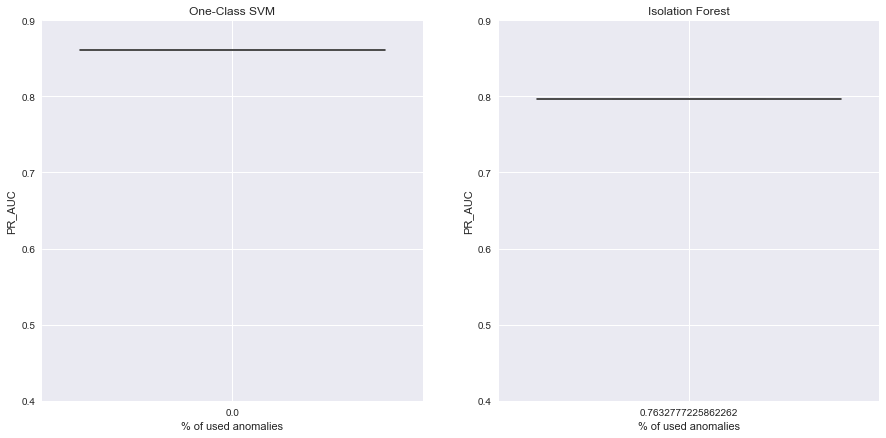

In [7]:
metric_boxplot(unsupervised_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))

ROC AUC для One-Class SVM и Isolation Forest

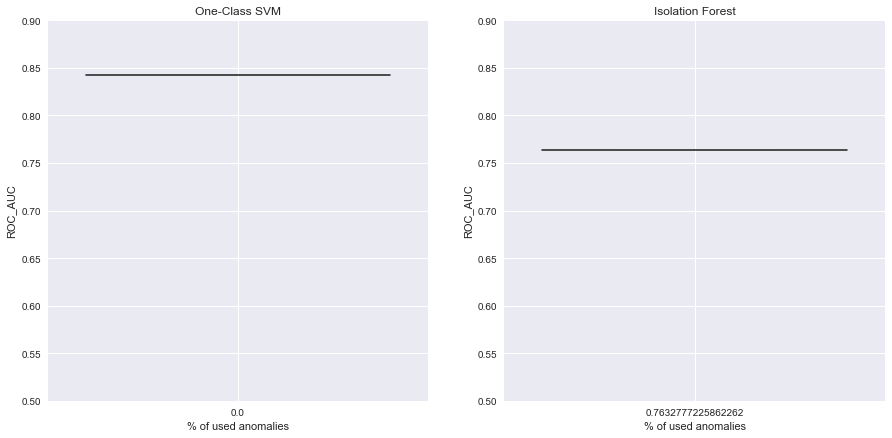

In [8]:
metric_boxplot(unsupervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.5, 0.9))

P@R:[0.8, 0.9, 0.95, 0.99] для One-Class SVM и Isolation Forest

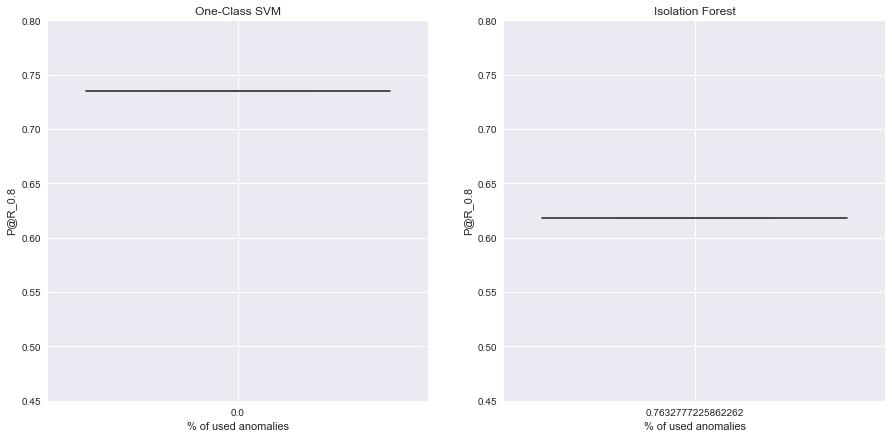

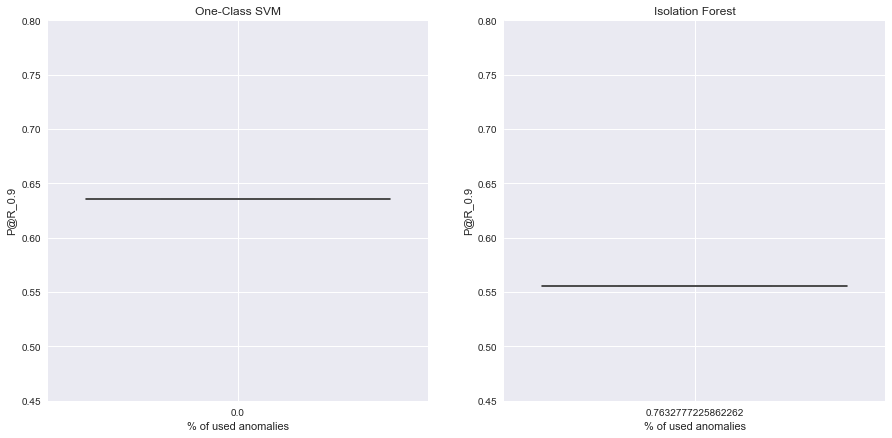

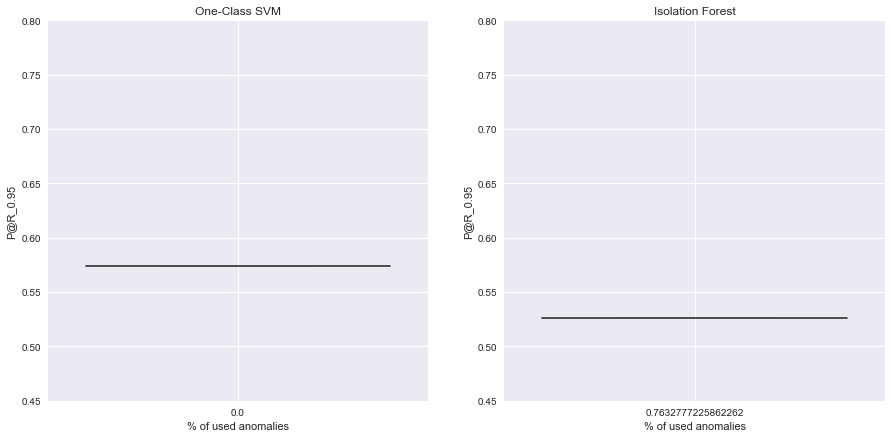

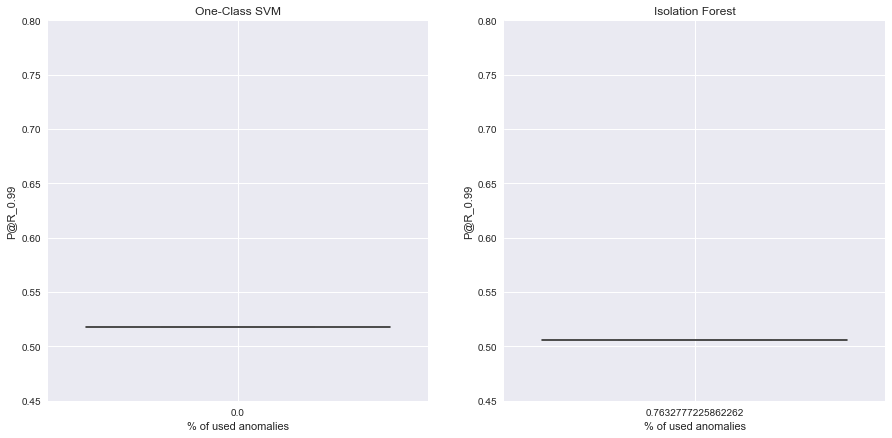

In [9]:
for k in unsupervised_p_at_r.keys():
    metric_boxplot(unsupervised_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.45, 0.8))
    plt.show()

# (1 + e) алгоритм

Загрузка метрик для (1 + e) алгоритмов(разные alpha, разные алгоритмы)

<a href="https://3.basecamp.com/3895643/buckets/5714528/messages/993962676">Про разные alpha</a>

Склеим разные alpha

In [10]:
alphas = list(map(str, [0, 0.1, 0.25, 0.5 ,1]))
metrics_path = './metrics/our/alpha_'
metrics_paths = [metrics_path + alpha for alpha in alphas]

ours_pr_aucs, ours_roc_aucs, ours_p_at_r = init_metrics(metrics_paths)

#### title == alpha value

In [11]:
len(ours_pr_aucs['0.1'])

99

In [12]:
len(ours_pr_aucs['0.25'])

100

In [13]:
len(ours_pr_aucs['0.5'])

100

In [14]:
len(ours_pr_aucs['0'])

100

In [15]:
len(ours_pr_aucs['1'])

98

PR AUC для (1 + e)

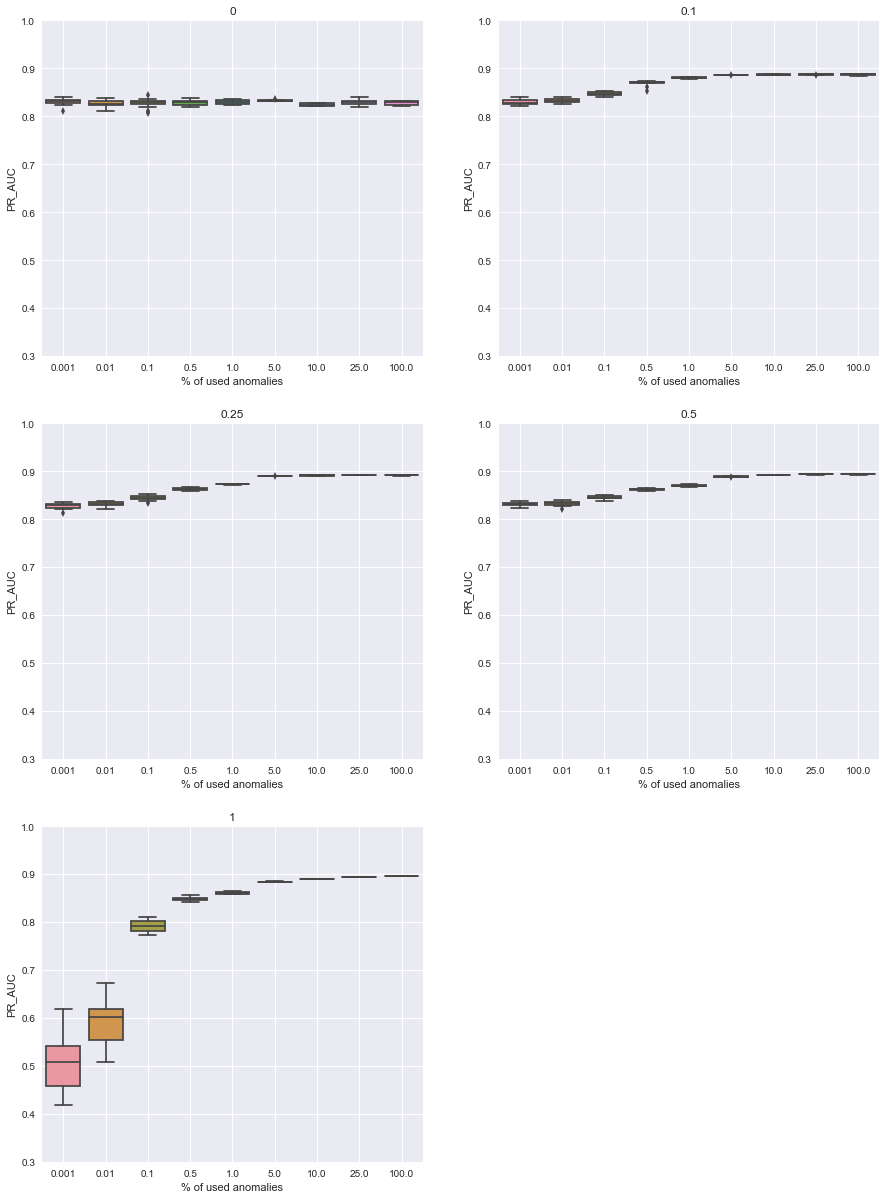

In [16]:
metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.3, 1))

ROC AUC для (1 + e)

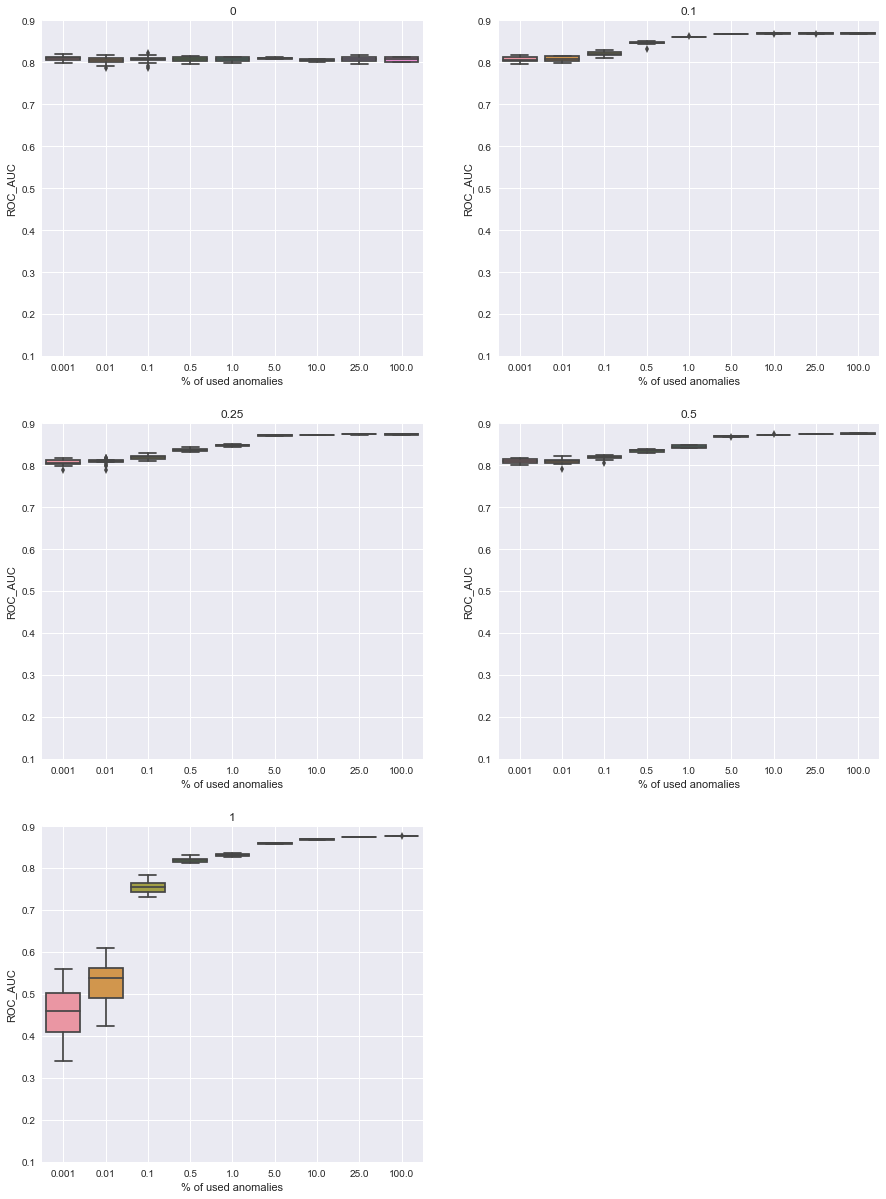

In [17]:
metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.1, 0.9))

P@R:[0.8, 0.9, 0.95, 0.99] для (1 + e)

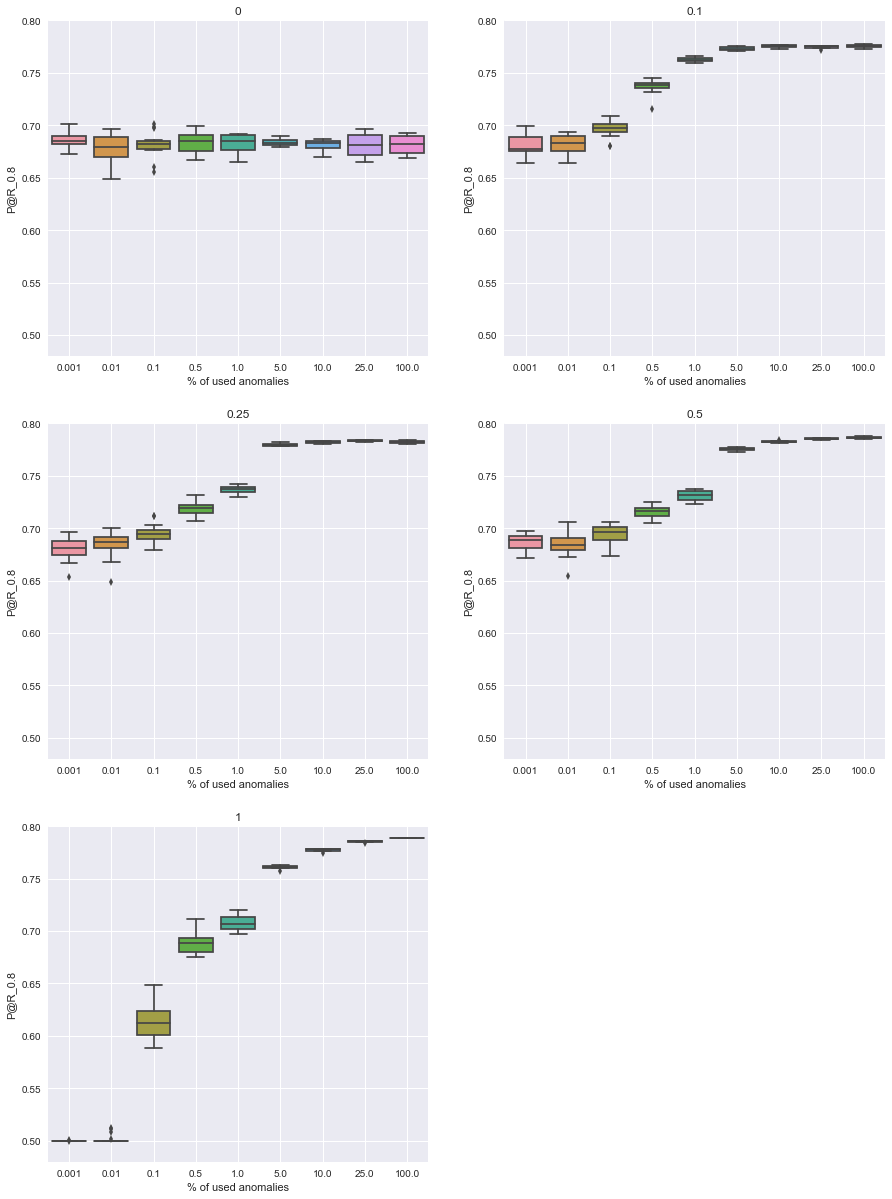

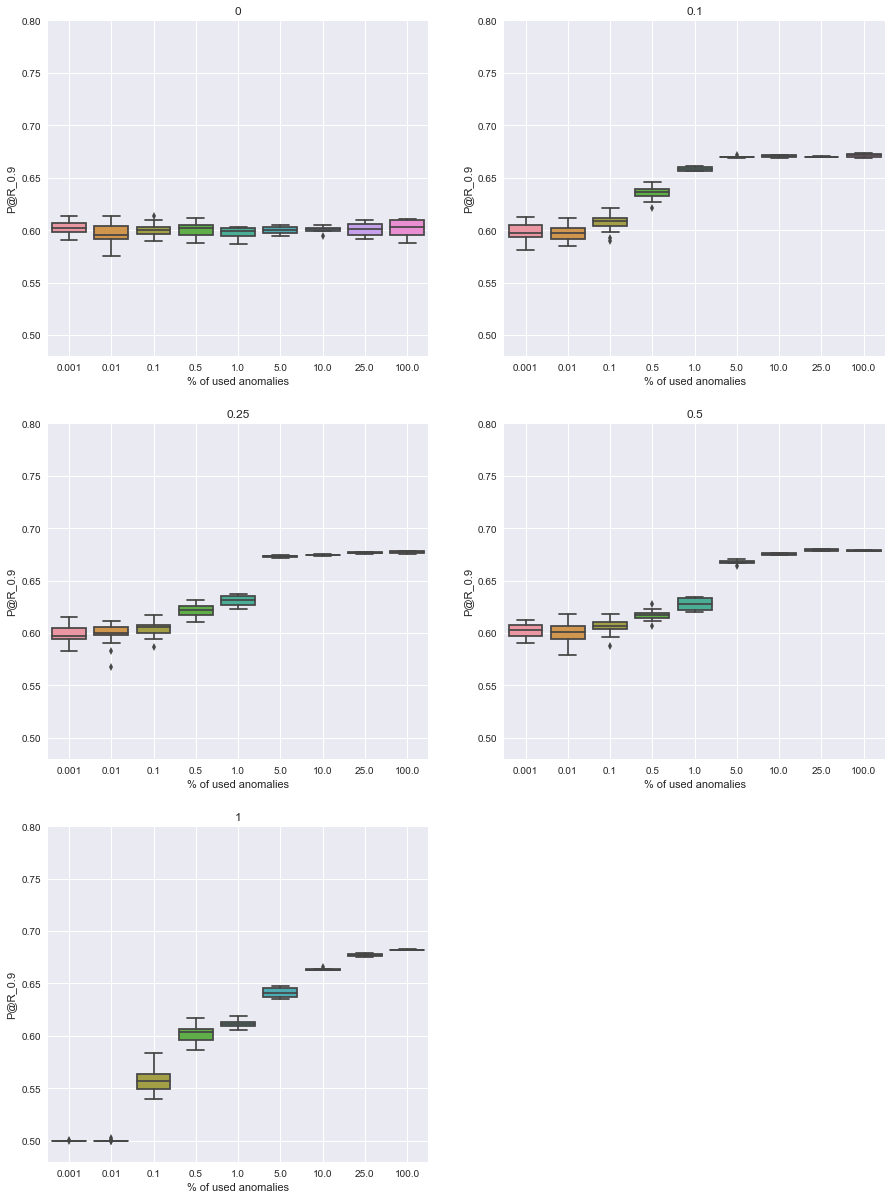

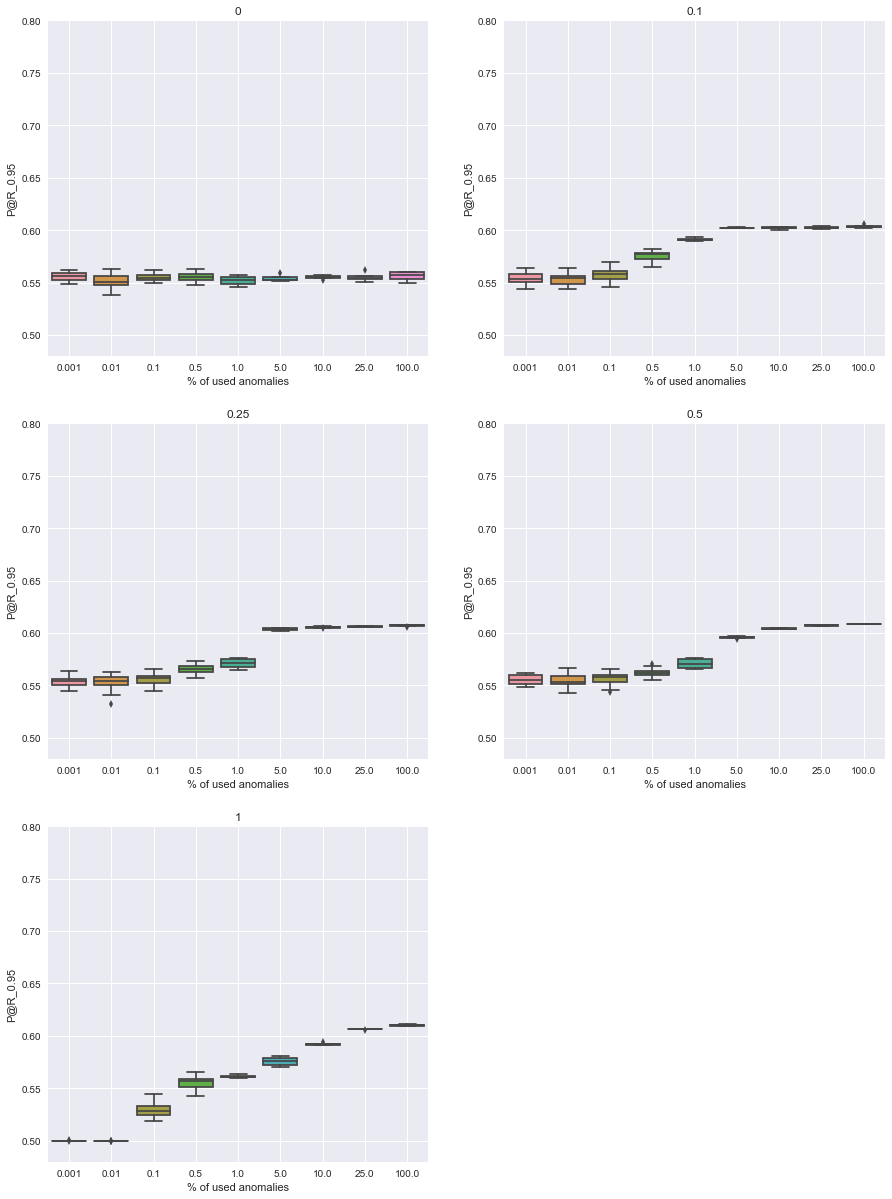

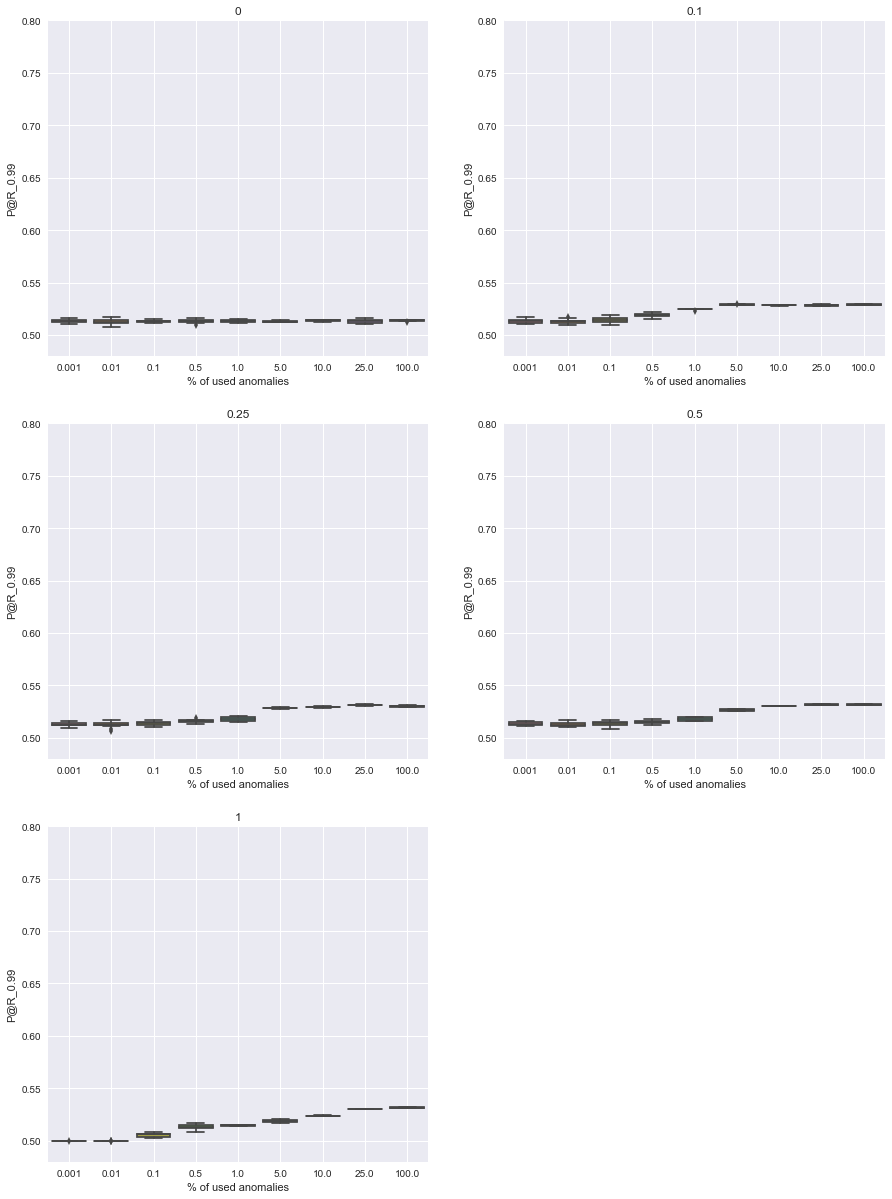

In [18]:
for k in ours_p_at_r.keys():
    metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.48, 0.8))
    plt.show()

## Построим все алгоритмы на одном графике

Усреднение значений метрики по долям используемых аномалий(нужно для supervised и ours)

In [19]:
mean_metric(supervised_pr_aucs['XGB_opt'])

[[1e-05, 0.6892248238956721],
 [0.0001, 0.8147503864531404],
 [0.001, 0.8490553691808888],
 [0.005, 0.8622246462370582],
 [0.01, 0.8675890679216177],
 [0.05, 0.8796772804401221],
 [0.1, 0.8844779043145629],
 [0.25, 0.8886915611315241],
 [1.0, 0.8918328830969947]]

Дублируем значения метрик на все доли используемых аномалий(нужно для unsupervised)

In [20]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.

In [21]:
unsupervised_pr_aucs['Isolation Forest']

[[0.0076327772258622615, 0.7969763937681634]]

In [22]:
dublicate_metric(unsupervised_pr_aucs['Isolation Forest'], fraction_of_negative_used)

[[1e-05, 0.7969763937681634],
 [0.0001, 0.7969763937681634],
 [0.001, 0.7969763937681634],
 [0.005, 0.7969763937681634],
 [0.01, 0.7969763937681634],
 [0.05, 0.7969763937681634],
 [0.1, 0.7969763937681634],
 [0.25, 0.7969763937681634],
 [1.0, 0.7969763937681634]]

Теперь выравняем измерения для различных алгоритмов по значениям fraction_of_negative_used

In [23]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [24]:
all_methods

['One-Class SVM',
 'Isolation Forest',
 '0',
 '0.1',
 '0.25',
 '0.5',
 '1',
 'XGB_opt']

In [25]:
ours_pr_aucs.keys()

dict_keys(['0', '0.1', '0.25', '0.5', '1'])

Из словарей {классификатор: метрика} делает один для всех классификаторов с выровненными по размеру значениями

In [26]:
pr_s = create_metrics_dict_by_clf(
    unsupervised_pr_aucs, supervised_pr_aucs, ours_pr_aucs, fraction_of_negative_used
)

In [27]:
roc_s = create_metrics_dict_by_clf(
    unsupervised_roc_aucs, supervised_roc_aucs, ours_roc_aucs, fraction_of_negative_used
)

In [28]:
p_at_r_s = {}
for key in ours_p_at_r.keys():
    p_at_r_s[key] = create_metrics_dict_by_clf(
        unsupervised_p_at_r[key], supervised_p_at_r[key], ours_p_at_r[key], fraction_of_negative_used
    )

##  Графики средних значений

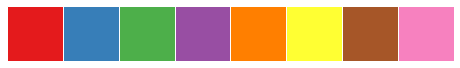

In [29]:
sns.palplot(sns.color_palette("Set1", len(all_methods[:9])))

In [30]:
cmap = sns.color_palette("Set1", len(all_methods[:9]))

#### PR AUC

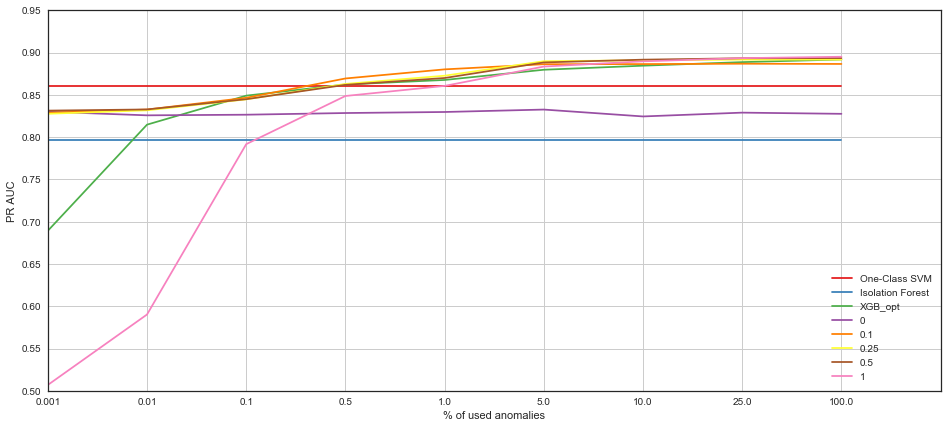

In [31]:
plot_means(pr_s, ylabel="PR AUC", y_lim=(0.5, 0.95), cmap=cmap)

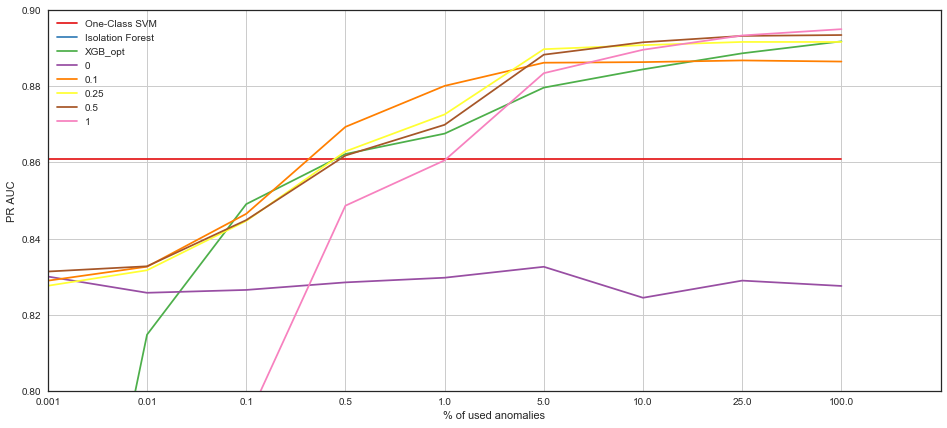

In [32]:
plot_means(pr_s, ylabel="PR AUC", y_lim=(0.8, 0.9), cmap=cmap)

#### ROC AUC

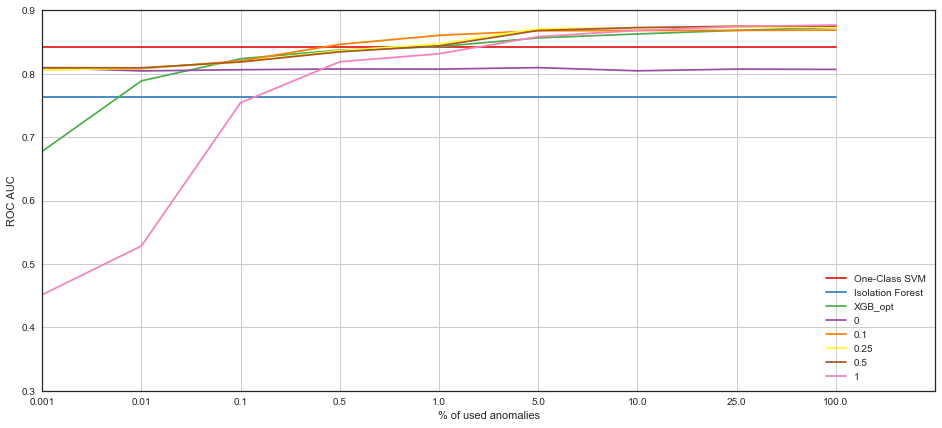

In [33]:
plot_means(roc_s, ylabel="ROC AUC", y_lim=(0.3, 0.9), cmap=cmap)

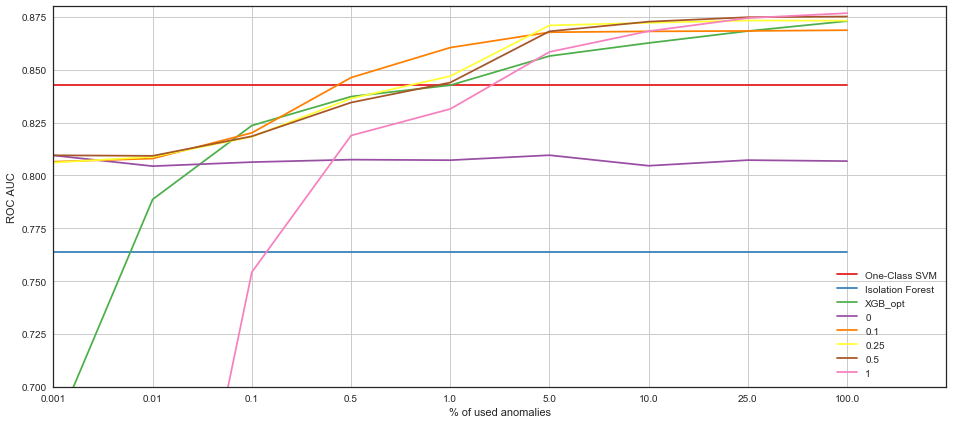

In [34]:
plot_means(roc_s, ylabel="ROC AUC", y_lim=(0.7, 0.88), cmap=cmap)

#### Precision at recall

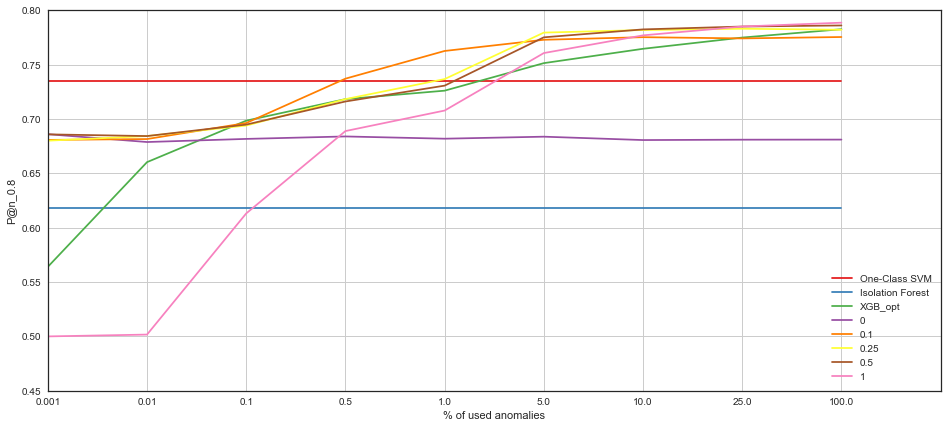

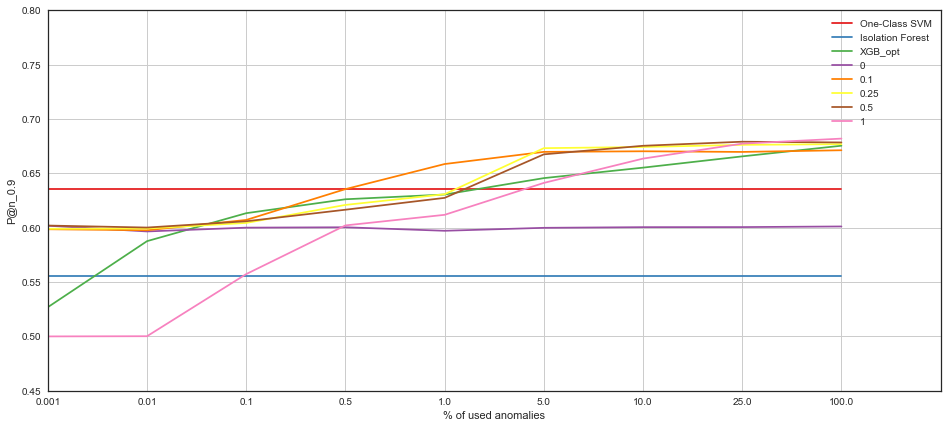

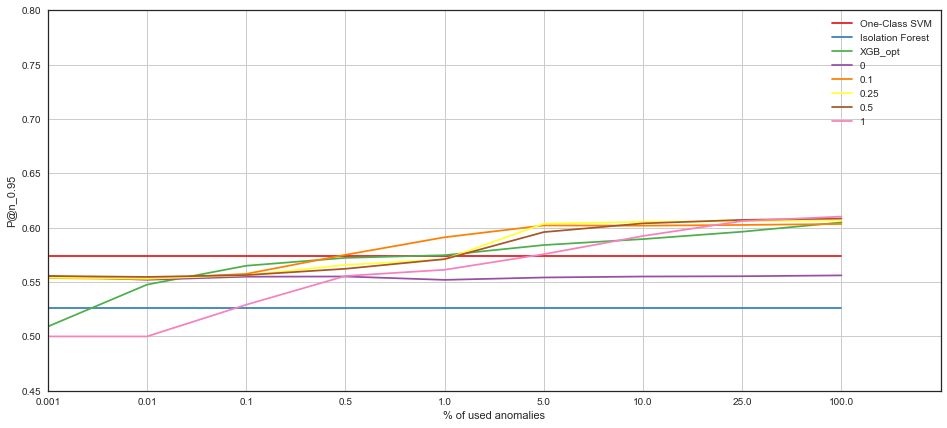

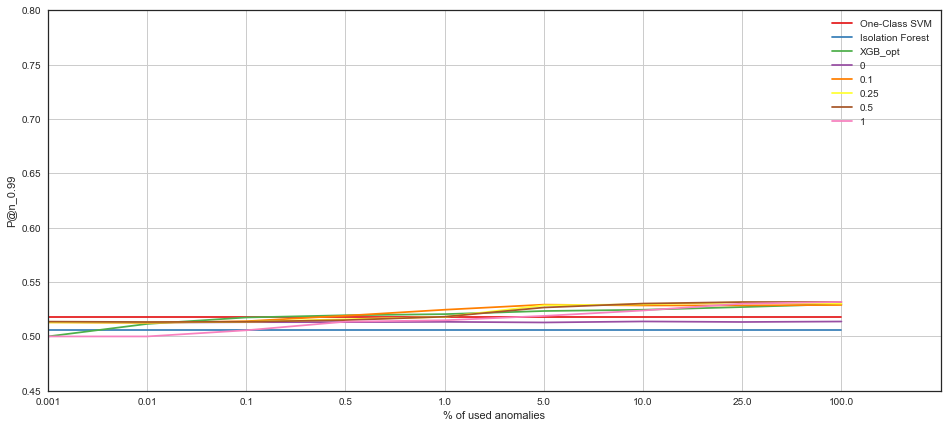

In [35]:
for key in p_at_r_s.keys():
    plot_means(p_at_r_s[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8), cmap=cmap)

# Графики с погрешностями

In [36]:
lower_percentile = (100 - 68)/2
upper_percentile = 100 - (100 - 68)/2
print("Построим перцентили ", lower_percentile, ' и ', upper_percentile)

Построим перцентили  16.0  и  84.0


In [37]:
get_percentiles(supervised_pr_aucs['XGB_opt'], lower_percentile, upper_percentile)

([[1e-05, 0.6070408748094513],
  [0.0001, 0.799635080567394],
  [0.001, 0.8451755119684623],
  [0.005, 0.8604634976533427],
  [0.01, 0.8667041257011712],
  [0.05, 0.8791929680274594],
  [0.1, 0.8840216031167701],
  [0.25, 0.8884588751161429],
  [1.0, 0.8917818947325846]],
 [[1e-05, 0.7512619807490829],
  [0.0001, 0.8379534082159023],
  [0.001, 0.8533985415161114],
  [0.005, 0.8638980392839339],
  [0.01, 0.8685974893214787],
  [0.05, 0.8801437274390922],
  [0.1, 0.8847788585504719],
  [0.25, 0.8888928533299254],
  [1.0, 0.891880195840018]])

Из словарей {классификатор: метрика} делает один для всех классификаторов с выровненными по размеру значениями

In [38]:
pr_s_per = create_metrics_dict_by_clf_with_percentile(
    unsupervised_pr_aucs, supervised_pr_aucs, ours_pr_aucs, 
    fraction_of_negative_used, lower_percentile, upper_percentile
)

In [39]:
roc_s_per = create_metrics_dict_by_clf_with_percentile(
    unsupervised_roc_aucs, supervised_roc_aucs, ours_roc_aucs,
    fraction_of_negative_used, lower_percentile, upper_percentile
)

In [40]:
p_at_r_s_per = {}
for key in ours_p_at_r.keys():
    p_at_r_s_per[key] = create_metrics_dict_by_clf_with_percentile(
        unsupervised_p_at_r[key], supervised_p_at_r[key], ours_p_at_r[key],
        fraction_of_negative_used, lower_percentile, upper_percentile
    )

Построение графиков с заливкой

In [41]:
lower_percentile = (100 - 68)/2
upper_percentile = 100 - (100 - 68)/2
print("Построим перцентили ", lower_percentile, ' и ', upper_percentile)

Построим перцентили  16.0  и  84.0


### Построим графики для всех алгоритмов

In [42]:
clf_names = [
    'One-Class SVM', 'Isolation Forest', 
    'XGB_opt',
    '0', 
    '0.1', 
    '0.25', 
    '0.5', 
    '1',
]

#### PR AUC

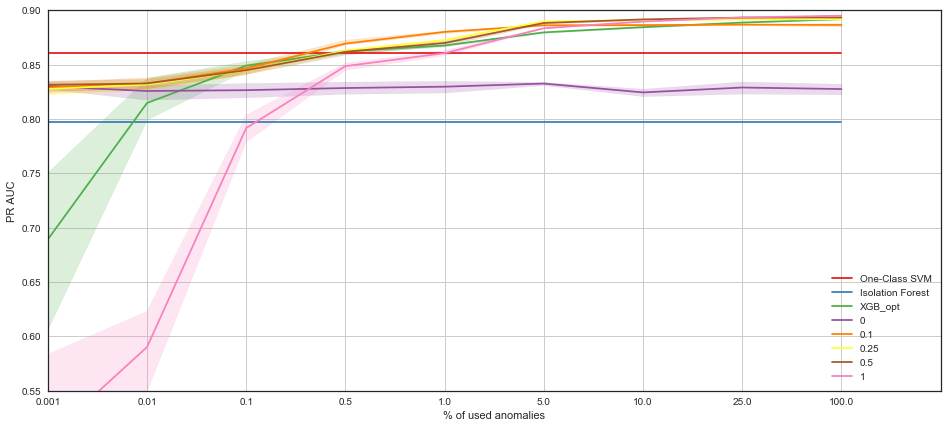

In [43]:
plot_means_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.55, 0.9), cmap=cmap, clf_names=clf_names)

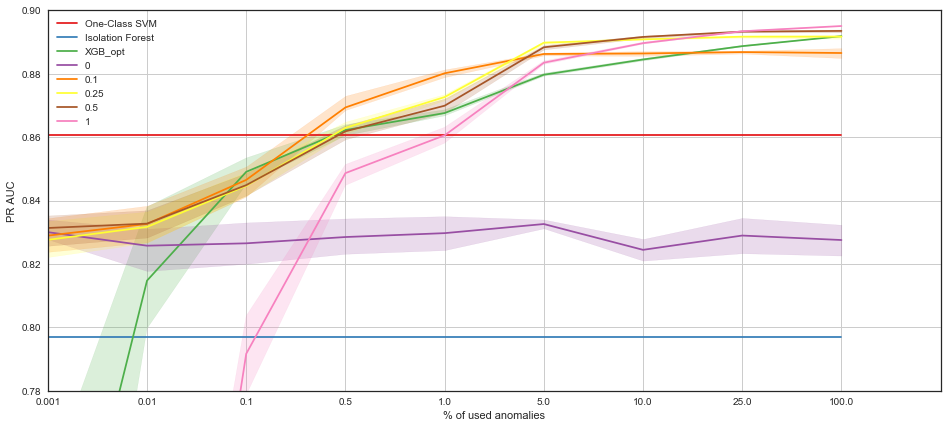

In [44]:
plot_means_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.78, 0.9), cmap=cmap, clf_names=clf_names)

#### ROC AUC

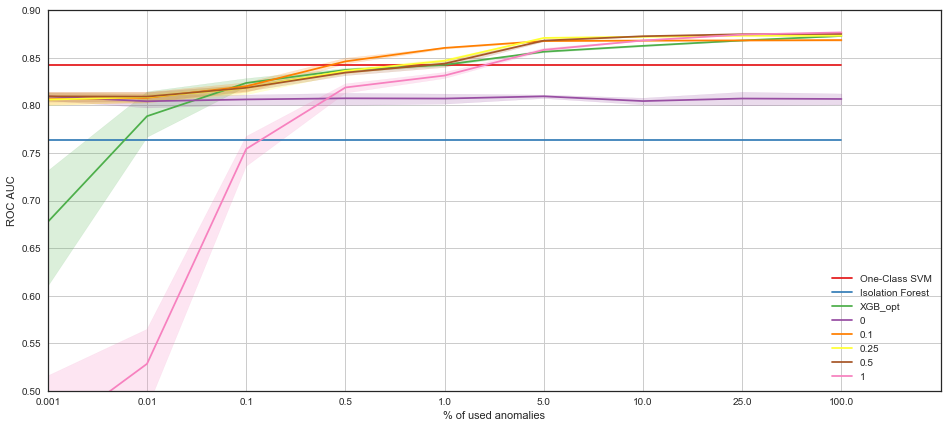

In [45]:
plot_means_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.5, 0.9), cmap=cmap, clf_names=clf_names)

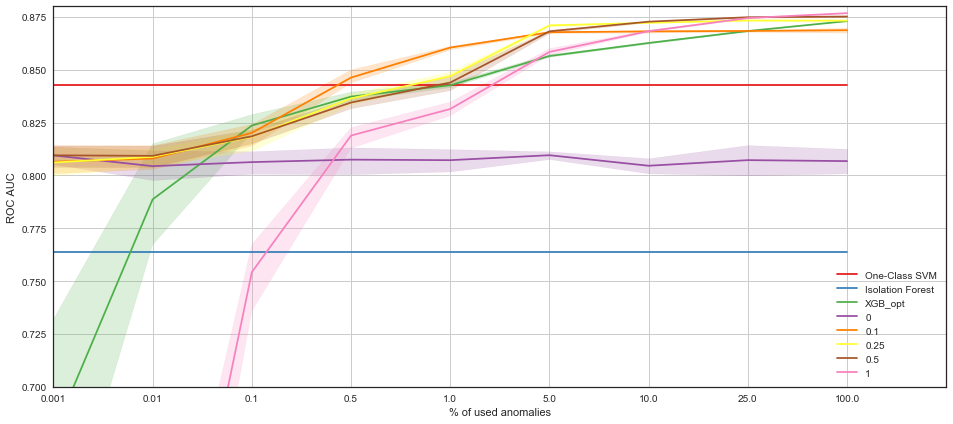

In [46]:
plot_means_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.7, 0.88), cmap=cmap, clf_names=clf_names)

#### Precision at recall

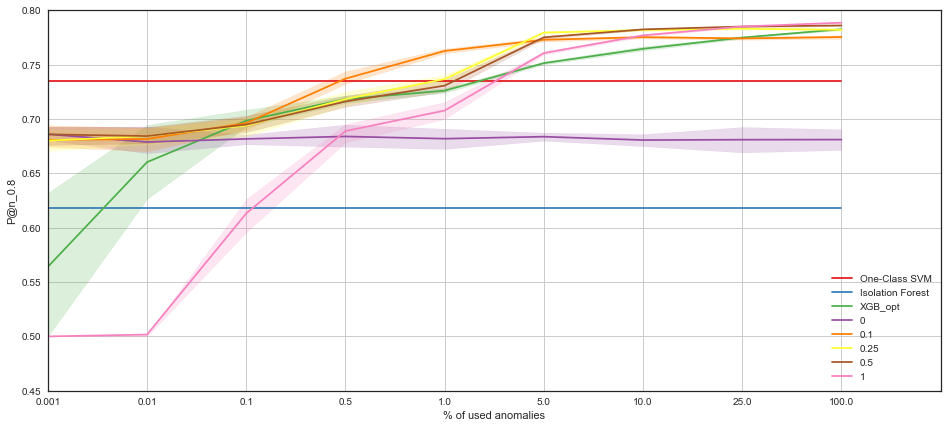

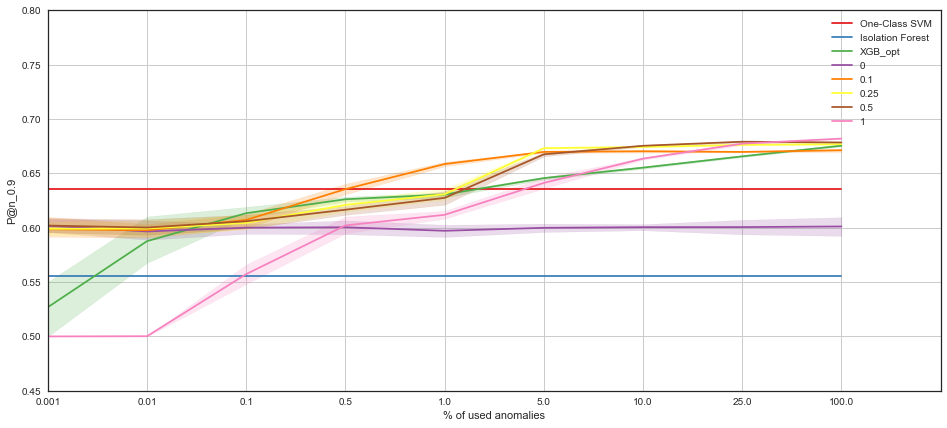

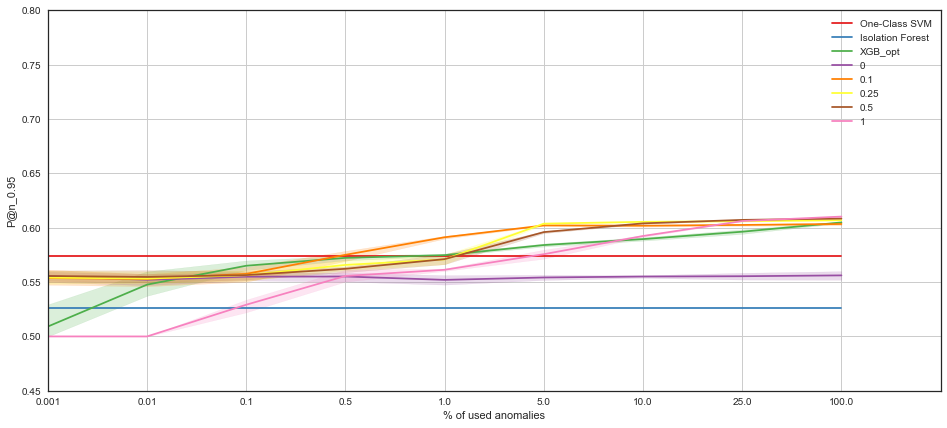

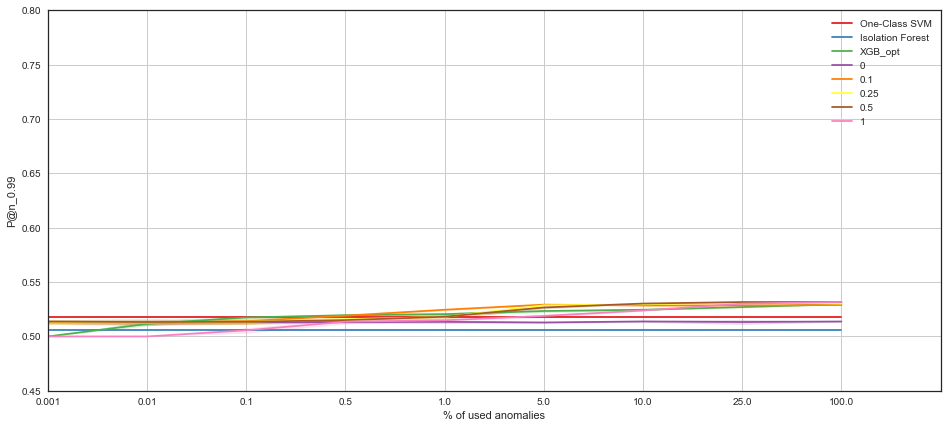

In [47]:
for key in p_at_r_s.keys():
    plot_means_with_percentile(p_at_r_s_per[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8),
                               cmap=cmap, clf_names=clf_names)

## Отобразим на графике только лучшие

In [48]:
clf_names = [
    'One-Class SVM', 
    'Isolation Forest', 
    'XGB_opt',
    '0', 
    '0.1', 
    '0.25', 
#     '0.5', 
#     '1',
]

#### PR AUC

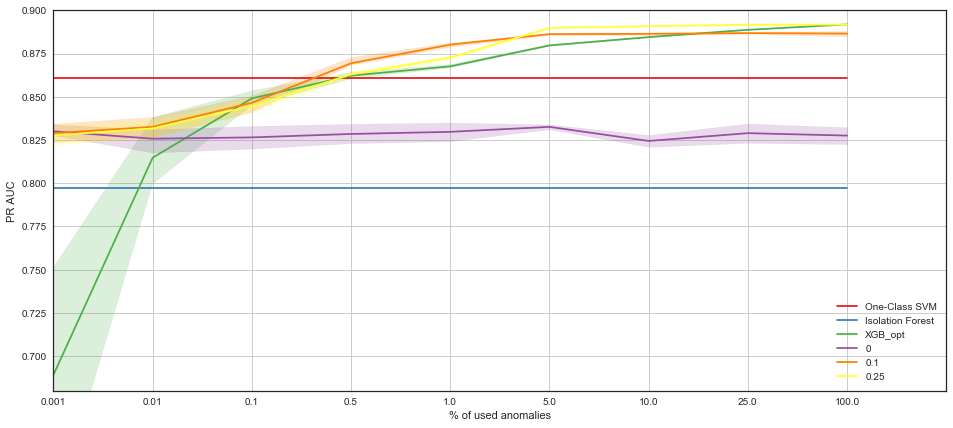

In [49]:
plot_means_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.68, 0.9), cmap=cmap, clf_names=clf_names)

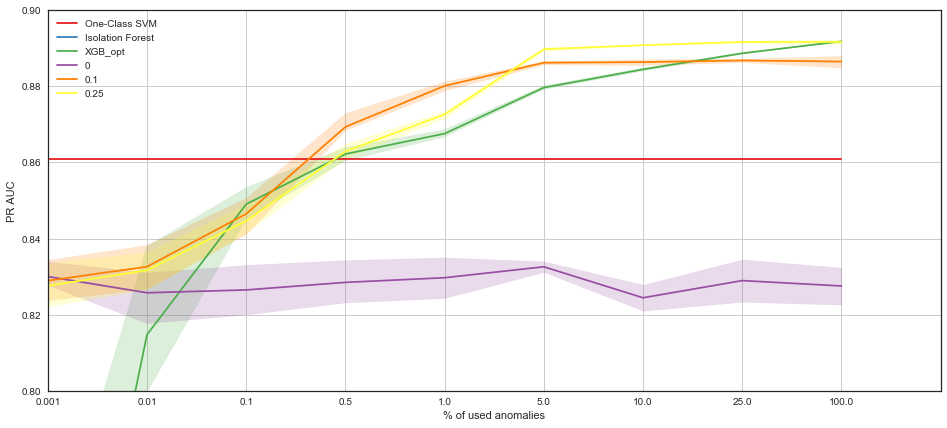

In [50]:
plot_means_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.8, 0.9), cmap=cmap, clf_names=clf_names)

#### ROC AUC

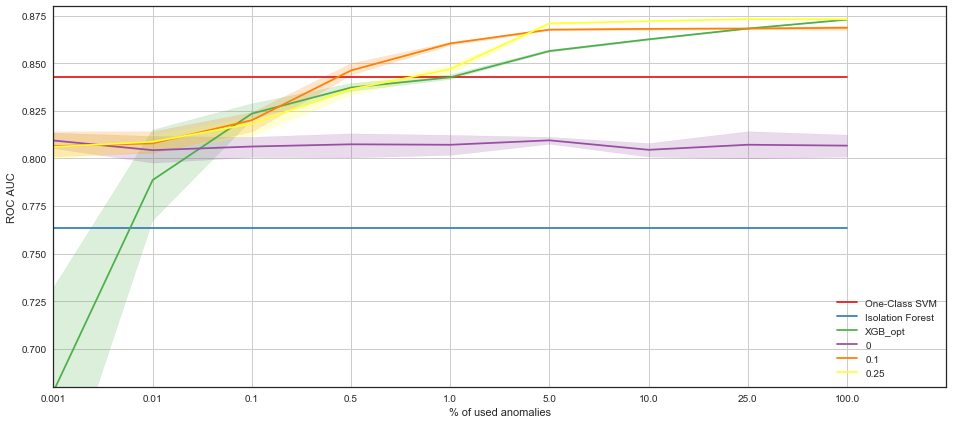

In [51]:
plot_means_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.68, 0.88), cmap=cmap, clf_names=clf_names)

#### Precision at recall

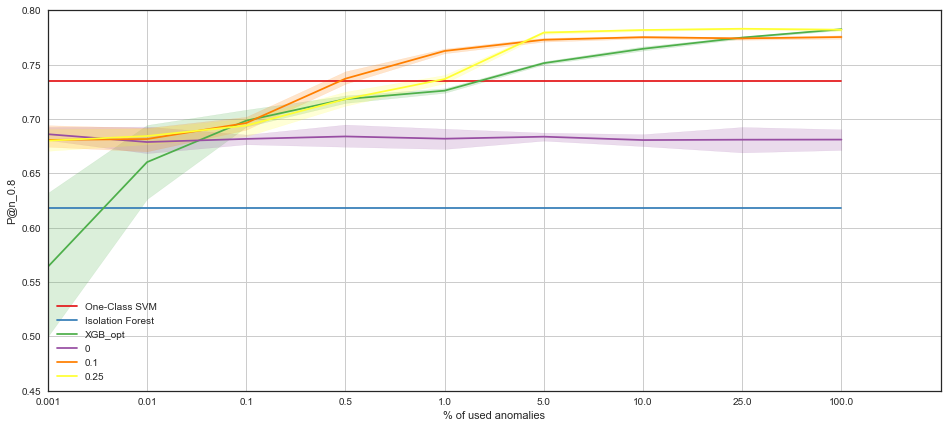

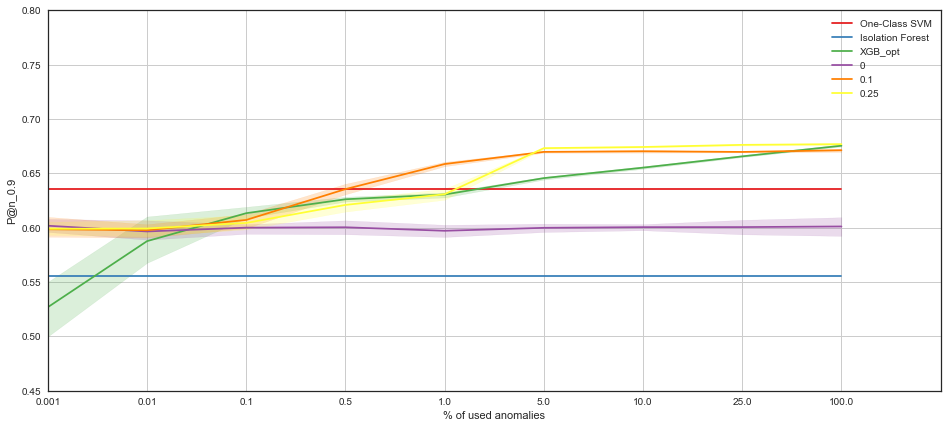

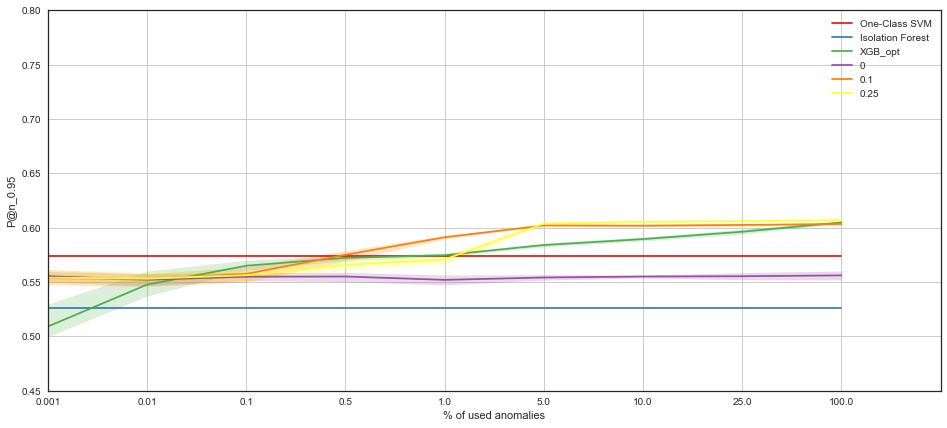

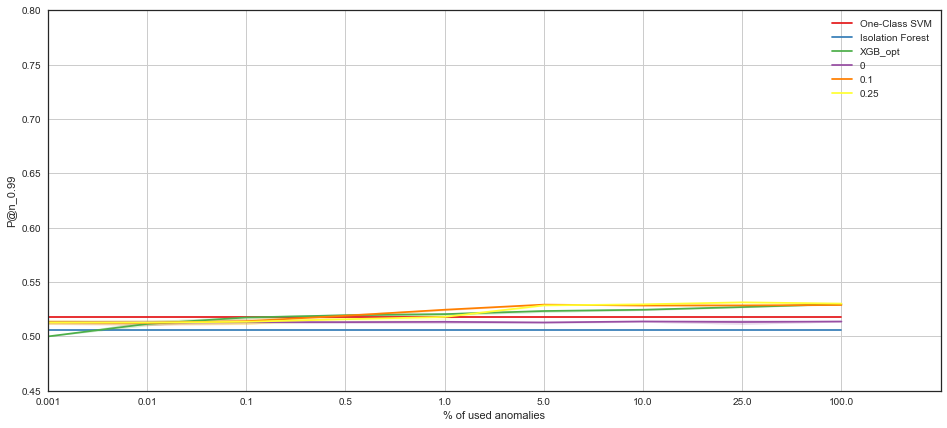

In [52]:
for key in p_at_r_s.keys():
    plot_means_with_percentile(p_at_r_s_per[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8),
                               cmap=cmap, clf_names=clf_names)